In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

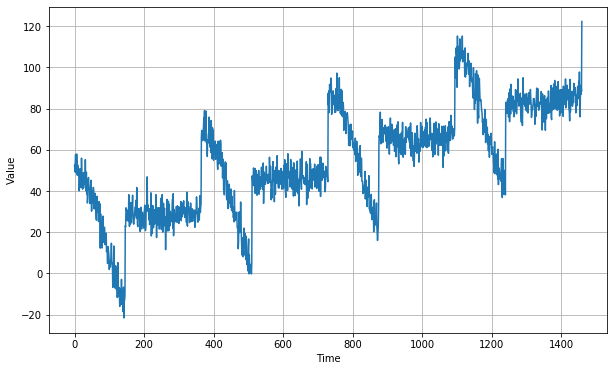

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Simple RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 336ms/step - loss: 49.5427 - mae: 50.8968
Epoch 2/100
8/8 [==============================] - 0s 54ms/step - loss: 22.4396 - mae: 23.2031
Epoch 3/100
8/8 [==============================] - 0s 55ms/step - loss: 18.4148 - mae: 19.5125
Epoch 4/100
8/8 [==============================] - 0s 54ms/step - loss: 16.8016 - mae: 17.3121
Epoch 5/100
8/8 [==============================] - 0s 53ms/step - loss: 15.7448 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 0s 55ms/step - loss: 14.9737 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 0s 53ms/step - loss: 14.3580 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 0s 55ms/step - loss: 14.3614 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 0s 55ms/step - loss: 14.2957 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 54ms/step - loss: 13.7645 - mae: 14.0410
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

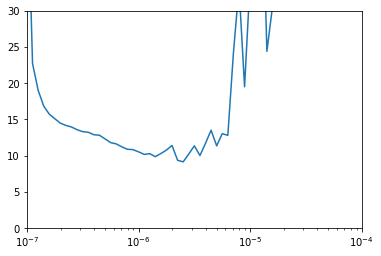

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 302ms/step - loss: 59.2328 - mae: 60.3563 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 70ms/step - loss: 37.5402 - mae: 37.3106 - val_loss: 11.4774 - val_mae: 11.7886
Epoch 3/500
8/8 [==============================] - 1s 68ms/step - loss: 24.1428 - mae: 24.0714 - val_loss: 12.7572 - val_mae: 13.0819
Epoch 4/500
8/8 [==============================] - 1s 73ms/step - loss: 17.0090 - mae: 17.6511 - val_loss: 21.4769 - val_mae: 22.3451
Epoch 5/500
8/8 [==============================] - 1s 71ms/step - loss: 14.3112 - mae: 14.3759 - val_loss: 10.0938 - val_mae: 10.6565
Epoch 6/500
8/8 [==============================] - 1s 67ms/step - loss: 11.7590 - mae: 12.0649 - val_loss: 11.5669 - val_mae: 12.0478
Epoch 7/500
8/8 [==============================] - 1s 71ms/step - loss: 10.8827 - mae: 11.4645 - val_loss: 8.4022 - val_mae: 8.9583
Epoch 8/500
8/8 [==============================] - 1s 70m

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

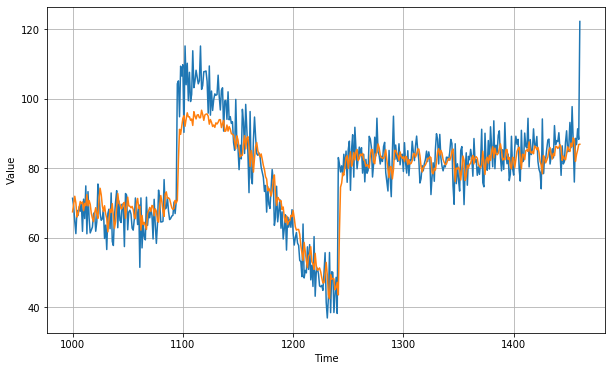

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.414168

## Sequence-to-Sequence Forecasting

In [0]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 276ms/step - loss: 51.7036 - mae: 53.0835
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 25.2292 - mae: 25.9614
Epoch 3/100
8/8 [==============================] - 0s 57ms/step - loss: 23.1568 - mae: 23.7153
Epoch 4/100
8/8 [==============================] - 0s 57ms/step - loss: 21.1219 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 19.5880 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 0s 54ms/step - loss: 18.7186 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 0s 55ms/step - loss: 18.1751 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 0s 58ms/step - loss: 17.9083 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 0s 58ms/step - loss: 17.5421 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 0s 56ms/step - loss: 17.3067 - mae: 17.5786
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

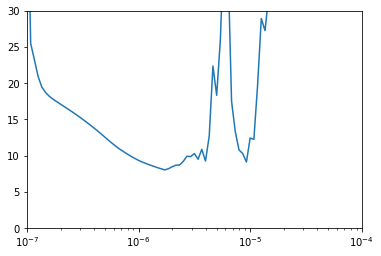

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 330ms/step - loss: 55.8599 - mae: 56.2827 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 73ms/step - loss: 33.6746 - mae: 35.1115 - val_loss: 17.4471 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 81ms/step - loss: 29.5658 - mae: 28.6514 - val_loss: 35.8526 - val_mae: 36.0965
Epoch 4/500
8/8 [==============================] - 1s 73ms/step - loss: 21.7688 - mae: 21.6919 - val_loss: 27.8289 - val_mae: 28.4824
Epoch 5/500
8/8 [==============================] - 1s 70ms/step - loss: 18.0302 - mae: 18.5032 - val_loss: 17.8703 - val_mae: 18.4261
Epoch 6/500
8/8 [==============================] - 1s 71ms/step - loss: 15.8201 - mae: 15.8192 - val_loss: 10.6282 - val_mae: 11.1625
Epoch 7/500
8/8 [==============================] - 1s 70ms/step - loss: 13.9125 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 73m

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

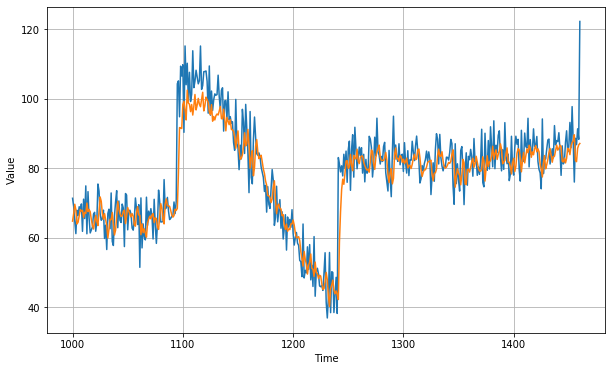

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.13363